# Парсинг данных с Кинопоиска по Турецким сериалам

## Парсинг списка объектов (сериалов)
Захожу на сайт Кинопоиска, где вытавлен фильтр на сериалы из Турции и прохожусь по всем страницам собирая данные
*Капча обходится с помощью selenium (дополнительных средств не понадобилось) и задержки по времени*

С помощью BeautifulSoup по тегам собираю следующие данные:

- title -Название сериала
- turkish_name - турецкое название сериала
- duration (in min.) - длительность серии в минутах
- years - годы выпуска сериала
- genre - жанр сериала
- director - главный режиссер сериала
- actor_1 - первый главный актер сеиала
- actor_2 - второй главный актер сериала
- ranking - рейтинг КиноПоиска
- num_marks - кол-во оценок сериала
- top-250 - место в Топ-250 КиноПоиска

Алгоритм:
1. Создаю функцию get_page - позволяет разобрать по тегам по каждому сериалу нужные данные
2. Циклом с помощью selenium прохожу по всем страницам с турецкими сериалами, которые есть на Кинопоиске (на момент создания 26 стр.) 

In [1]:
# !pip install requests
# !pip install fake_useragent
# !pip install selenium
# pip install tqdmd
# !pip install webdriver-manager

In [1]:
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
import requests
import re
import pandas as pd
import numpy as np
import time
from tqdm import tqdm
from bs4 import BeautifulSoup
from fake_useragent import UserAgent

kinopoisk = webdriver.Chrome(ChromeDriverManager().install())

kinopoisk.get("https://www.kinopoisk.ru/lists/movies/country--68/?b=series&page=1")

C:\Users\User\AppData\Local\Temp/ipykernel_8516/2312523362.py:13: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  kinopoisk = webdriver.Chrome(ChromeDriverManager().install())


In [2]:
info = []

def get_page(series):
    for s in series:
        d = dict.fromkeys(['title', 'turkish_name', 'duration (in min.)', 'years', 'genre', 'director',  
                           'actor_1', 'actor_2', 'ranking', 'num_marks', 'top-250'], np.nan)

        # название сериала
        d['title'] = s.find('div', {'class' : 'base-movie-main-info_mainInfo__ZL_u3'}).text

        # строка с информацией, каждый из элементов строки по отдельности может отсутств.:
        # название на турецком, годы выпуска, длительность серии
        if s.find('div', {'class' : 'desktop-list-main-info_secondaryTitleSlot__mc0mI'}) is not None:
            year_len = s.find('div', {'class' : 'desktop-list-main-info_secondaryTitleSlot__mc0mI'}).text.split(',')
            for element in year_len:
                if re.search(r'\d* мин.', element.strip().replace('\xa0', ' ')) is not None:
                    d['duration (in min.)'] = re.search(r'\d* мин.', element.strip().replace('\xa0', ' ')) \
                                                .group(0).replace(' мин.', '')        
                    continue

                if re.search('\d{4}–\d{4}', element) is not None:
                    d['years'] = re.search('\d{4}–\d{4}', element).group(0)
                    continue
                elif re.search('\d{4}–...', element) is not None:
                    d['years'] = re.search('\d{4}–...', element).group(0)
                    continue
                elif re.search('\d{4}', element) is not None:
                    d['years'] = re.search('\d{4}', element).group(0)
                    continue

                d['turkish_name'] = element

        # 2 строки под названием с доп. инф-й, которые закодированы одинаково, но несут разную инф-ю
        add_inf = ''
        actors = ''
        for item in s.find_all('div', {'class' : 'desktop-list-main-info_additionalInfo__Hqzof'}):
            if len(add_inf) == 0:
                add_inf = item.text.replace('Турция', '') \
                                   .replace('•', '').strip().split('\xa0')
                if '' in add_inf:
                    add_inf.remove('')
                if len(add_inf) != 0:
                    for item in add_inf:
                        if re.search('Режиссёр: ', item) is not None:
                            d['director'] = item.replace('Режиссёр: ', '')
                        else:
                            d['genre'] = item
                else:
                    add_inf = 'not empty'
            else:
                actors = item.text.replace('В ролях:', '')
        if len(actors) != 0:
            actors = actors.split(',')
            d['actor_1'] = actors[0]
            if len(actors) != 1: 
                d['actor_2'] = actors[1]

        # рейтинг сериала - разные оценки, а точнее цвета оценок, закодированы по-разному
        # У сериала может быть зеленый, серый, красный рейтинг.
        # Может стоять "—" либо не быть рейтинга - тогда это все интерпретирую как нет рейтинга NaN
        for color in ['styles_kinopoiskValuePositive__vOb2E', 'styles_kinopoiskValueNeutral__sW9QT',
                  'styles_kinopoiskValueNegative__Y75Rz']:
            if s.find('span', {'class' : color}) is not None:
                d['ranking'] = float(s.find('span', {'class' : color}).text)
                break

        # количество просмотров - также может и не быть
        if s.find('span', {'class' : 'styles_kinopoiskCount__2_VPQ'}) is not None:
            d['num_marks'] = int(s.find('span', {'class' : 'styles_kinopoiskCount__2_VPQ'}).text.replace(" ", ""))

        # есть ли в топ-250 кинопоиска. Если есть, то на каком месте
        if s.find('div', {'class' : 'styles_top250__KTSbT'}) is not None:
            d['top-250'] = s.find('div', {'class' : 'styles_top250__KTSbT'}).text.replace('Топ 250: ', '')

        info.append(d)

In [3]:
pages = []
for i in tqdm(list(range(1, 27))):
    try:
        useless_elki_ad = kinopoisk.find_element(By.CSS_SELECTOR, '#foxadspecial_popup_desktop > div > div.special-elki-9-first-elem-creative > div.special-elki-9-first-elem-creative__close')
        useless_elki_ad.click()
    except:
        pass
    web_page = kinopoisk.page_source
    tree = BeautifulSoup(web_page, 'lxml')
    series = tree.find_all('div', {'class' : 'styles_root__ti07r'})
    get_page(series)

    try:
        submit = kinopoisk.find_element(By.CSS_SELECTOR, "#__next > div.styles_root__goB3B > div.styles_middleContainer__vJjLN.styles_baseContainer__bGRTT > div.styles_mainContainer__59YLl > div.styles_contentSlot__h_lSN > main > div.styles_root__AT6_5.styles_root__RoFSb > a.styles_end__aEsmB.styles_start__UvE6T")
        kinopoisk.implicitly_wait(2) 
        submit.click()
    except:
        pass
    
kinopoisk.close()


100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [01:14<00:00,  2.87s/it]


In [4]:
df = pd.DataFrame(info)
df.head()

,title,turkish_name,duration (in min.),years,genre,director,actor_1,actor_2,ranking,num_marks,top-250
0,Постучись в мою дверь,Sen Çal Kapımı,45,2020–2021,мелодрама,Алтан Дёнмез,Ханде Эрчел,Керем Бюрсин,8.1,404196.0,NaN
1,Великолепный век,Muhtesem Yüzyil,100,2011–2014,мелодрама,Дурул Тайлан,Халит Эргенч,Мерьем Узерли,8.2,184704.0,NaN
2,Чёрная любовь,Kara Sevda,140,2015–2017,мелодрама,Хилаль Сарал,Бурак Озчивит,Неслихан Атагюль,8.3,113336.0,NaN
3,Ветреный,Hercai,120,2019–2021,драма,Джем Карджи,Акын Акынёзю,Эбру Шахин,7.7,80539.0,NaN
4,Великолепный век. Империя Кёсем,Muhtesem Yüzyil: Kösem,120,2015–2017,драма,Зейнеп Гюнай,Берен Саат,Хюлья Авшар,7.7,56487.0,NaN


## Сбор информации со страниц сериала - информация о **популярных** турецких сериалах
Попытался нажимать через selenium на каждый сериал и там собирать данные, однако выдает ошибку каждый раз в разный момент. Ошибка не из-за капчи, а, подозреваю, из-за проблем с прогрузкой страницы при возвращении обратно на страницу со списком сериалов.

Поэтому сохранил страницы самых **популярных** турецких сериалов (с 1-й страницы), распарсил и исследовал их.

Пытался собирать информацию, которой нет в таблице со всеми сериалами. 
Со страниц сериалов получены данные:
- title - название сериала
- reviews - количество рецензий на сериал
- prod_year - год произодства сериала	
- seasons - кол-во сезонов
- genres - все жанры сериала
- slogan - слоган сериала
- directors - режиссеры сериала
- screenwriters - сценаристы сериала
- producers - продюсеры сериала
- operators - операторы сериала
- composers - композиторы сериала
- artists - художники сериала
- editors - монтажеры сериала
- budget - бюджет сериала
- world_premier - дата премьеры
- age_limit - возрастное ограничение
- duration_in_min - длительность серии
- kinopoisk_rank - рейтинг КиноПоиска
- IMDb - рейтинг IMDb	
- actors - список актеров сериала

Алгоритм:
1. Создаю функцию парсинга информации со страницы сериала
2. Захожу на все страницы (сохраненные локально, поэтому path необходимо сменить)

In [5]:
iii = []
def page_series(tree):
    d = dict.fromkeys(['title', 'reviews', 'prod_year', 'seasons', 'genres', 'slogan', 'directors',
                       'screenwriters', 'producers', 'operators', 'composers', 'artists', 'editors',
                       'budget', 'world_premier', 'age_limit', 'duration_in_min', 
                       'kinopoisk_rank', 'IMDb', 'actors'], np.nan)
    
    d['title'] = tree.find('span', {'data-tid' : '2da92aed'}).text
    try:
        d['reviews'] = tree.find('div', {'data-tid' : 'd87cf2dd'}).text
    except:
        pass
    
    content_table = tree.find_all('div', {'data-tid' : '7cda04a5'})
    
    for i, item in enumerate(content_table):
        content_table[i] = item.getText(separator=u' ').split()
        if 'Год' in content_table[i] and 'производства' in content_table[i]:
            d['prod_year'] = int(content_table[i][content_table[i].index('производства') + 1])
            for item in content_table[i]:
                if 'сезон' in item:
                    d['seasons'] = int(content_table[i][content_table[i].index(re.search('сезон\w*', item).group(0))-1])
        if 'Жанр' in content_table[i]:
            d['genres'] = ' '.join(content_table[i][1:]).replace(' , ', ', ').replace('слова', '')
        if 'Слоган' in content_table[i] and '—' not in content_table[i]:
            d['slogan'] = ' '.join(content_table[i][1:]).replace(' , ', ', ')
        if 'Режиссер' in content_table[i]:
            d['directors'] = ' '.join(content_table[i][1:]).replace(' , ', ', ')
        if 'Сценарий' in content_table[i]:
            d['screenwriters'] = ' '.join(content_table[i][1:]).replace(' , ', ', ')
        if 'Продюсер' in content_table[i]:
            d['producers'] = ' '.join(content_table[i][1:]).replace(' , ', ', ')
        if 'Оператор' in content_table[i]:
            d['operators'] = ' '.join(content_table[i][1:]).replace(' , ', ', ')
        if 'Композитор' in content_table[i]:
            d['composers'] = ' '.join(content_table[i][1:]).replace(' , ', ', ')
        if 'Художник' in content_table[i]:
            d['artists'] = ' '.join(content_table[i][1:]).replace(' , ', ', ')
        if 'Монтаж' in content_table[i]:
            d['editors'] = ' '.join(content_table[i][1:]).replace(' , ', ', ')
        if 'Бюджет' in content_table[i]:
            d['budget'] = ' '.join(content_table[i][1:]).replace(' , ', ', ')
        if 'Премьера' in content_table[i] and 'мире' in content_table[i]:
            d['world_premier'] = ' '.join(content_table[i][3:]) 
        if 'Возраст' in content_table[i]:
            d['age_limit'] = content_table[i][1]
        if 'Время' in content_table[i] and '—' not in content_table[i]:
            d['duration_in_min'] = int(content_table[i][1])

    try:
        a = tree.find_all('li', {'data-tid' : '2e6eb73e'})
        for i, item in enumerate(a):
            a[i] = item.text
        d['actors'] = a
    except:
        pass
        
    try:
        d['kinopoisk_rank'] = float(tree.find('a', {'class' : 'film-rating-value styles_rootLink__mm0kW'}).text)
    except:
        pass
    
    try:
        d['IMDb'] = float(tree.find('span', {'class' : 'styles_valueSection__0Tcsy'}).text.replace('IMDb: ', ''))
    except:
        pass
    
    iii.append(d)
    return iii

In [6]:
for n in range(1, 52):
    path = r'C:\Users\User\Documents\parsing_pages\{}.html'.format(n)
    
    with open(path, encoding="utf-8") as file:
        x = file.read()
    tree = BeautifulSoup(x, 'html')
    page_series(tree)

In [7]:
data = pd.DataFrame(iii)
data['reviews'] = data['reviews'].str.replace(r'\D', '', regex=True).astype(float)
data.head()

,title,reviews,prod_year,seasons,genres,slogan,directors,screenwriters,producers,operators,composers,artists,editors,budget,world_premier,age_limit,duration_in_min,kinopoisk_rank,IMDb,actors
0,Постучись в мою дверь,24.0,2020,2.0,"мелодрама, комедия",NaN,"Алтан Дёнмез, Эндер Михлар, Юсуф Пирхасан","Эрдем Ачикгёз, Ешим Чытак, Дилек Иигюн, ...","Зейнеп Бильгич, Асена Бюльбюльолу","Хакан Генджан, Озгюр Демир, Илькер Эрдоан",Айтекин Аташ,Серкан Озер,"Умут Озан Болукоглу, Мурат Коджак",NaN,"8 июля 2020 , ...",16+,45.0,8.1,7.1,"[Ханде Эрчел, Керем Бюрсин, Эврим Доан, Аныл И..."
1,Великолепный век,88.0,2011,4.0,"мелодрама, история, военный, биография, драма",«Любовь сквозь века»,"Дурул Тайлан, Ягмур Тайлан, Ягыз Алп Акайдын, ...","Мераль Окай, Йылмаз Шахин",Тимур Савджи,"Эрджан Озкан, Бурак Канбир, Айдын Сарыоглу","Айтекин Аташ, Фахир Атакоглу, Сонер Акалын",NaN,NaN,TRL 4 000 000,"5 января 2011 , ...",16+,100.0,8.2,6.8,"[Халит Эргенч, Мерьем Узерли, Селен Озтюрк, Гю..."
2,Чёрная любовь,13.0,2015,1.0,мелодрама,NaN,"Хилаль Сарал, Экин Пандир","Аныл Эке, Бурджу Гёргюн Топташ, Озлем Йылмаз","Толга Афшин Кая, Керем Чатай",Толга Четин,Тойгар Ышыклы,Онур Туг,"Гёкче Бильгин Кылыч, Дуйгу Килич",NaN,"14 сентября 2015 , ...",16+,140.0,8.3,7.3,"[Бурак Озчивит, Неслихан Атагюль, Каан Ургандж..."
3,Ветреный,3.0,2019,3.0,"драма, мелодрама",«Impossible love tale of vengeance»,"Джем Карджи, Benal Tahiri, Али Ильхан, ...","Bersan Tan, Zeynep Yalgin, Feraye Sahin, ...",Бану Акдениз,Али Аслан,"Метин Аригюль, Эндер Гюндюзлю","Бану Акдениз, Дилек Сезгин, Бурак Озджан","Сердар Чакулар, Мерт Джан Асал, Эмрах Демирташ",NaN,"15 марта 2019 , ...",16+,120.0,7.7,6.6,"[Акын Акынёзю, Эбру Шахин, Айда Аксель, Маджит..."
4,Великолепный век. Империя Кёсем,14.0,2015,2.0,"драма, мелодрама, история",«Сила невинности»,"Зейнеп Гюнай, Мерт Байкал, Ягыз Алп Акайдын, ...","Йылмаз Шахин, Озен Юла",Тимур Савджи,"Хакан Окумуш, Али Мурат Алтынышык",Айтекин Аташ,"Нилюфер Чамур, Сердар Башбюг","Мештян Сакаллы, Исмаил Акбулут, Гокхан Гюрсес",NaN,"12 ноября 2015 , ...",16+,120.0,7.7,6.6,"[Берен Саат, Хюлья Авшар, Эркан Колчак Кёстенд..."


## Анализ данных полученных с сайта
Анализ будет проведен по следующим направлениям:
1. График самых рейтинговых и самых часто оцениваемых турецких сериалов
2. График рейтинга турецких сериалов от количества оценок
3. График самых популярных актеров и их рейтингов
4. Изменение рейтинга турецких сериалов по годам
5. Выведу информацию о средних значениях по количественным переменным и топы встречаемости по текстовым переменным для **популярных** турецких сериалов 
6. Зависимость жанра **популярного** турецкого сериала и его рейтнга 

In [8]:
import matplotlib.pyplot as plt 
%matplotlib inline 

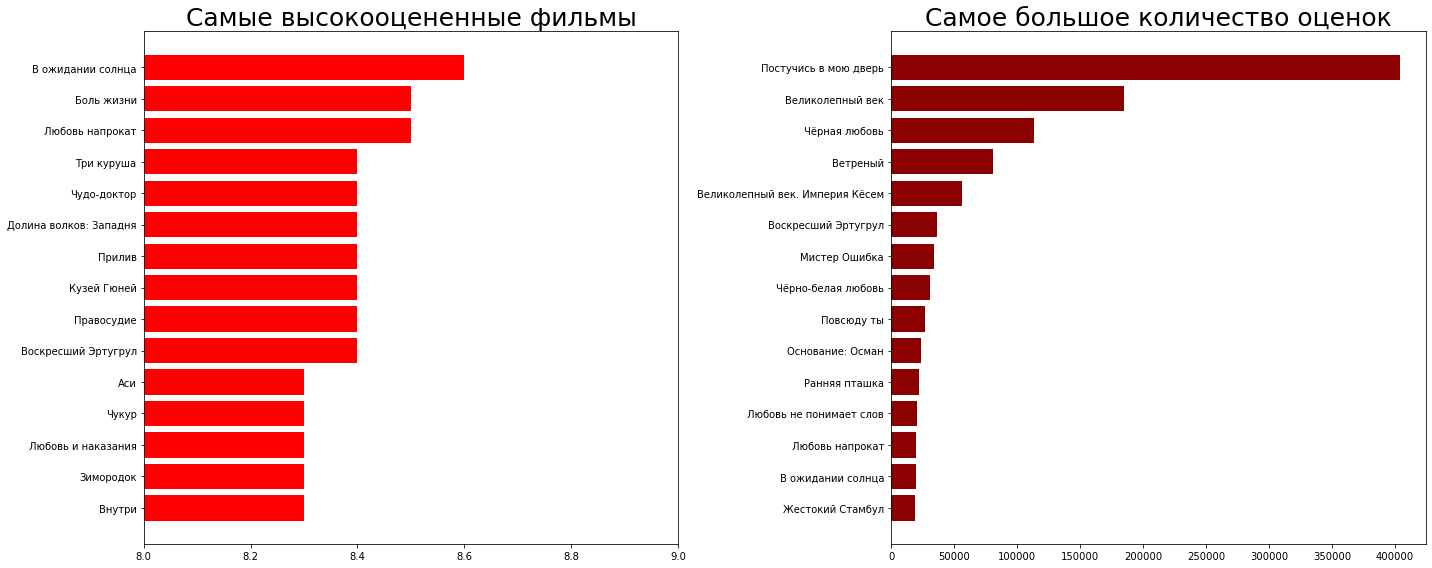

In [9]:
top_list = df[['title', 'ranking', 'num_marks']] \
            .loc[df['num_marks'].notna()] \
            .loc[df['ranking'].notna()].sort_values('ranking')

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))


ax[0].barh(top_list['title'].tail(15), top_list['ranking'].tail(15), color='r')
ax[0].set_title('Самые высокооцененные фильмы', size=25)
ax[0].set_xlim(8, 9)

ax[1].barh(top_list.sort_values('num_marks')['title'].tail(15), 
           top_list.sort_values('num_marks')['num_marks'].tail(15), color='darkred')
ax[1].set_title('Самое большое количество оценок', size=25)
plt.tight_layout()

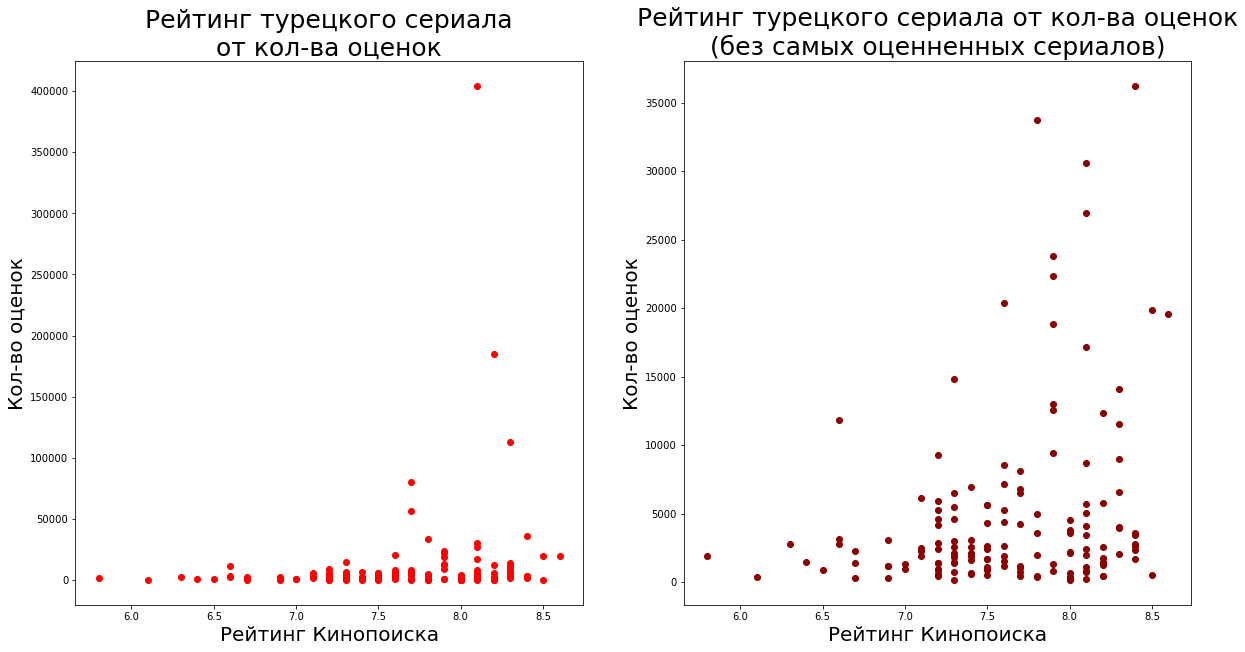

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
ax[0].scatter(top_list['ranking'], top_list['num_marks'], color='r')
ax[1].scatter(top_list['ranking'][top_list['num_marks'] < 50000], 
              top_list['num_marks'][top_list['num_marks'] < 50000],
              color='darkred');

ax[0].set_title('Рейтинг турецкого сериала\nот кол-ва оценок', size=25)
ax[1].set_title('Рейтинг турецкого сериала от кол-ва оценок\n(без самых оценненных сериалов)', size=25)

for i in range(0, 2):
    ax[i].set_xlabel('Рейтинг Кинопоиска', size=20)
    ax[i].set_ylabel('Кол-во оценок', size=20)

In [11]:
dff1 = df.copy().drop(columns='actor_2')
dff2 = df.copy().drop(columns='actor_1').rename(columns={'actor_2': 'actor_1'})
ddff = dff1.append(dff2).reset_index(drop=True)
counts = ddff.groupby('actor_1').agg({'title': 'count'}).sort_values('title').reset_index()
actors_array = ddff.loc[ddff['ranking'].notna()][['actor_1', 'ranking']]
means = actors_array.groupby('actor_1').agg({'ranking': 'mean'}).sort_values('ranking').reset_index()

actors_info_table = pd.merge(counts, means, how='left', on='actor_1')

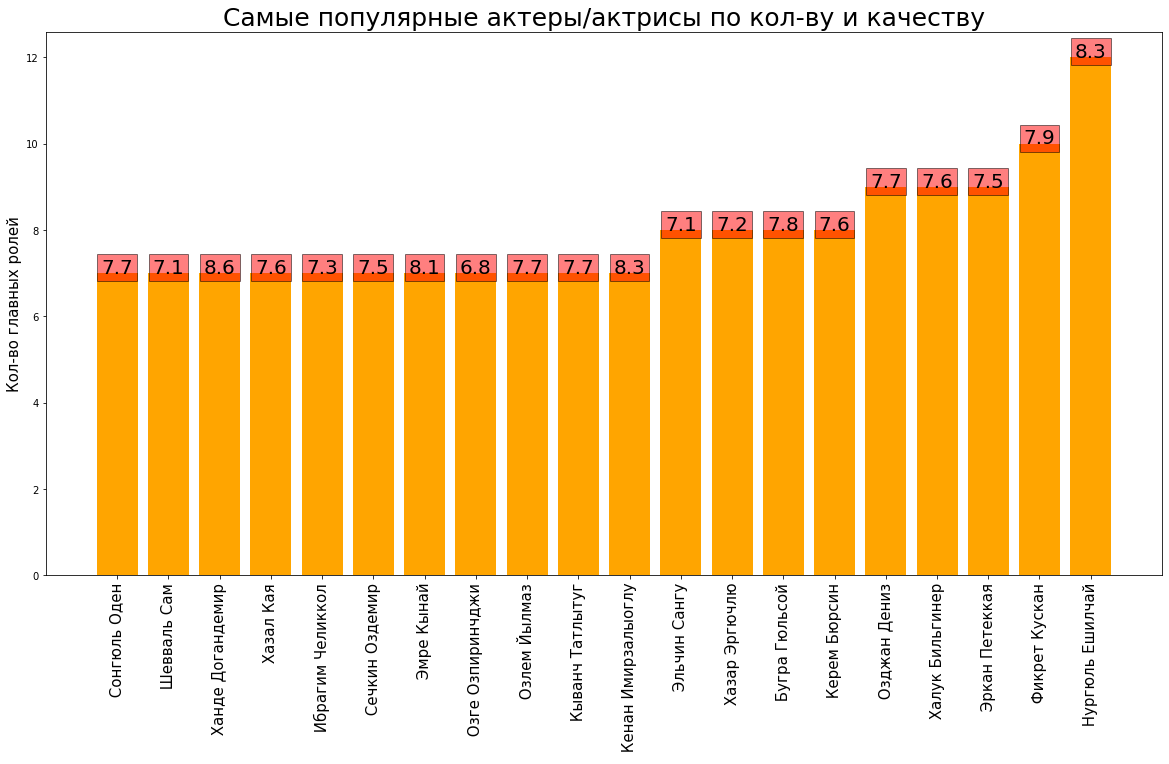

In [12]:
actors_info_table = actors_info_table[actors_info_table.ranking.notna()]

def addlabels(x, y, v, col='red', sz=20, ha='center'):
    x = list(x)
    y = list(y)
    v = list(v)
    for i in range(len(x)):
        plt.text(i, y[i], round(v[i], 1), ha = ha,
                 bbox = dict(facecolor = col, alpha =.5), size=sz);

plt.figure(figsize = (20, 10))
plt.bar(actors_info_table['actor_1'].tail(20), actors_info_table['title'].tail(20), color='orange');
      
    # calling the function to add value labels
addlabels(actors_info_table['actor_1'].tail(20), actors_info_table['title'].tail(20),
          actors_info_table['ranking'].tail(20))

plt.title("Самые популярные актеры/актрисы по кол-ву и качеству", size=25)
plt.xticks(rotation = 90, size=15)
plt.ylabel('Количество главных ролей', size=15)
      
    # giving X and Y labels
plt.ylabel("Кол-во главных ролей")

plt.show();

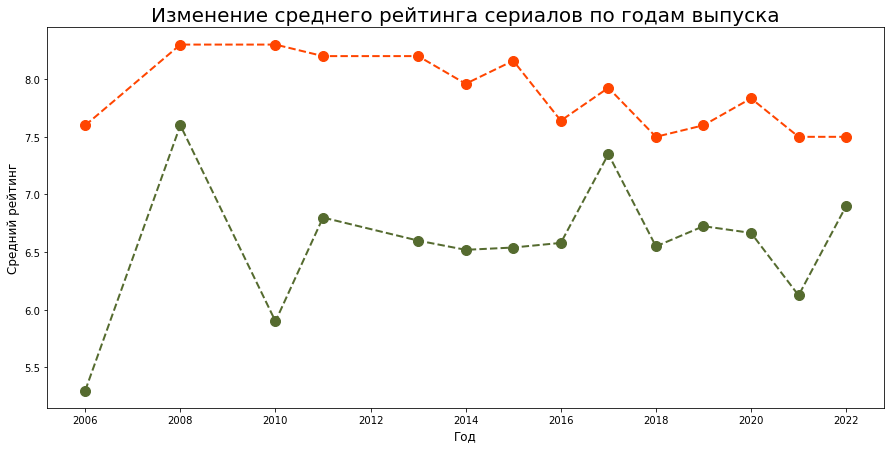

In [13]:
ratings = data.groupby('prod_year').agg({'kinopoisk_rank': 'mean', 'IMDb': 'mean'}).reset_index()

fig, ax = plt.subplots(figsize=(15, 7)) 
ax.plot(ratings['prod_year'][ratings['prod_year'] > 2005], 
        ratings['kinopoisk_rank'][ratings['prod_year'] > 2005], color = 'orangered',
        ls='--', lw=2, marker='o', ms=10)

ax.plot(ratings['prod_year'][ratings['prod_year'] > 2005], 
        ratings['IMDb'][ratings['prod_year'] > 2005], color = 'darkolivegreen',
        ls='--', lw=2, marker='o', ms=10)

ax.set_xlabel('Год', fontsize=12)
ax.set_ylabel('Средний рейтинг', fontsize=12)

ax.set_title('Изменение среднего рейтинга сериалов по годам выпуска', size=20);

In [14]:
print(f"""Среднее кол-во сезонов самых популярных турецких сериалов: {data['seasons'].mean()}
Среднее кол-во написанных рецензий на популярный турецкий сериал: {round(data['reviews'].mean())}
Средний рейтинг популярного турецкого сериала: Кинопоиск: {round(data['kinopoisk_rank'].mean(), 1)}, IMDb: {round(data['IMDb'].mean(), 1)}
Средняя длительность одной серии популярного турецкого сериала: {data['duration_in_min'].mean()} мин.
В основном возрастное ограничение для турецкого сериала: {data['age_limit'].value_counts().index[0]}
""")

directors = [row.replace(', ...', '').split(', ') for row in data['directors']]
directors = pd.Series([director for i in directors for director in i])

screenwriters = [row.replace(', ...', '').split(', ') for row in data['screenwriters']]
screenwriters = pd.Series([screenwriter for i in screenwriters for screenwriter in i])

producers = [row.replace(', ...', '').split(', ') for row in data['producers']]
producers = pd.Series([producer for i in producers for producer in i])

genres = [row.replace(', ...', '').split(', ') for row in data['genres']]
genres = pd.Series([genre.replace(' ', '') for i in genres for genre in i])

print(f"""Самые популярные режиссеры: {', '.join(list(directors.value_counts().index[0:3]))}
Самые популярные сценаристы: {', '.join(list(screenwriters.value_counts().index[0:3]))}
Самые популярные продюсеры: {', '.join(list(producers.value_counts().index[0:3]))}
Самые популярные жанры: {genres.value_counts().index[0]} - {genres.value_counts().iloc[0]} сериалов, 
                        {genres.value_counts().index[1]} - {genres.value_counts().iloc[1]} сериала,
                        {genres.value_counts().index[2]} - {genres.value_counts().iloc[2]} сериалов""")

Среднее кол-во сезонов самых популярных турецких сериалов: 1.7
Среднее кол-во написанных рецензий на популярный турецкий сериал: 8
Средний рейтинг популярного турецкого сериала: Кинопоиск: 7.8, IMDb: 6.6
Средняя длительность одной серии популярного турецкого сериала: 114.66 мин.
В основном возрастное ограничение для турецкого сериала: 16+

Самые популярные режиссеры: Хилаль Сарал, Алтан Дёнмез, Метин Гюнай
Самые популярные сценаристы: Бану Зенгин Так, Аслы Зенгин, Мелек Генчоглу
Самые популярные продюсеры: Керем Чатай, Фарук Тургут, Али Гюндогду
Самые популярные жанры: драма - 35 сериалов, 
                        мелодрама - 34 сериала,
                        комедия - 16 сериалов


In [15]:
genres_criteria = data.copy()

name_dict = {'melodrama': 'мелодрама', 'drama': 'драма', 'comedy': 'комедия', 'action': 'боевик', 
             'history': 'история', 'military': 'военный', 'thriller': 'триллер', 'criminal': 'криминал'}
rank_dict = dict.fromkeys(name_dict.keys())
imdb_rank = dict.fromkeys(name_dict.keys())

for element in name_dict:
    genres_criteria[element] = np.nan
    genres_criteria[element][genres_criteria['genres'].str.contains(name_dict[element])] = 1
    rank_dict[element] = round(genres_criteria['kinopoisk_rank'][genres_criteria[element] == 1].mean(), 1)
    imdb_rank[element] = round(genres_criteria['IMDb'][genres_criteria[element] == 1].mean(), 1)
    

C:\Users\User\AppData\Local\Temp/ipykernel_8516/1408779142.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genres_criteria[element][genres_criteria['genres'].str.contains(name_dict[element])] = 1


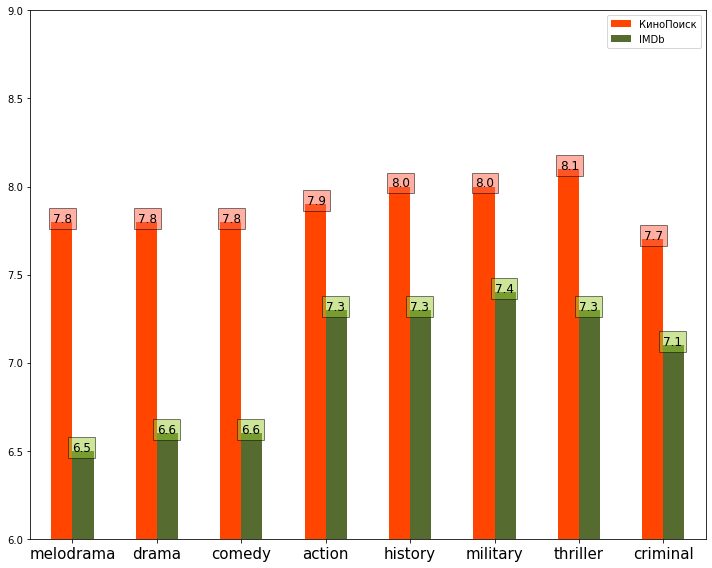

In [16]:
dict_of_marks = {'КиноПоиск': rank_dict.values(), 'IMDb': imdb_rank.values()}
table_genre_rating = pd.DataFrame(dict_of_marks, index=name_dict.keys())

fig, ax = plt.subplots(figsize=(10, 8))
table_genre_rating.plot(kind='bar', ax=ax, color=['orangered','darkolivegreen'])
plt.xticks(rotation = 0, size=15)
plt.ylim(6, 9)

addlabels(table_genre_rating.index, table_genre_rating['КиноПоиск'], 
          table_genre_rating['КиноПоиск'], 'tomato', 12, 'right')
addlabels(table_genre_rating.index, table_genre_rating['IMDb'], 
          table_genre_rating['IMDb'], 'yellowgreen', 12, 'left')



plt.tight_layout()

## Выводы
1. Самый рейтинговый турецкий сериал НЕ РАВНО самый часто оцениваемый (по крайней мере для российского зрителя, пользующегося КиноПоиском), т.е. у сериала с хорошим рейтингом может быть мало оценок, поэтому он завышен.
Но при этом мало оценивают сериалы с маленьким рейтингом
2. Чтобы оценивать эти данные, вероятно, придется избавиться от сериалов с самым большим кол-вом оценок (т.к. мало сериалов, имеющих кол-во оценок больше 50 тыс.), т.е. они будут выбросами, но тогда нужно правильно оценивать являются ли оставшиеся малооцененные сериалы показательными
3. Самые популярные актеры по кол-ву главных ролей: Нургюль Ешилчай, Фикрет Кускан. Самый рейтинговый по сериалам - Ханде Догандемир (8.6), но и главных ролей у него поменьше.
4. По версии КиноПоиска самые рейтинговые **популярные** турецкие сериалы выходили с 2008 по 2013 года, а в последние годы качество упало до оценки примерно 7.5.
По версии IMDb перепадов в качестве больше, но самые успешные по рейтингу года для **популярных** турецких сериалов - 2008, 2017
5. Чаще всего турки снимают драмы, мелодрамы и комедии.
По версии Кинопоиска качество по жанрам у всех **популярных** турецких сериалов примерно одно и то же (у триллера и военного чуть больше, но встречаются они гораздо реже).
В IMDB также ставят самым популярным жанрам турецких сериалов оценки ниже, но это связано также с большей представленностью в выборке 
